In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

In [3]:
print(tf.__version__)

2.12.0


In [4]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics
        print(self.print_metrics)

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x and x in self.print_metrics]

        f, axs = plt.subplots(len(metrics)//2 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['val_loss']))*0.8, max(max(history.history['loss']), max(history.history['val_loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [5]:
# Carrega o dataset de treino

dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['time_as_client', 'profit', 'compliant'])

# Define o objetivo de regressão: gasto mensal
target = 'monthly_spend'

In [6]:
# Separa em dataset de treino (90%) e validação (10%)
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# Separa em features e labels (objetivo)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

features = test_features.columns.drop(target)

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

# Define uma camada de normalização
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


In [8]:
# Definição de um modelo
def build_and_compile_model(norm):

    # Ativações não lineares (relu) e lineares
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='linear'),
        layers.Dense(64, activation='linear'),
        layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])

    # Define o schedule da taxa de aprendizagem, começando com 0.5 e decaindo exponencialmente
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.5,
                    decay_steps = 1000,
                    decay_rate=10,
                    staircase=False)

    # Compila o modelo com o objetivo de Erro Absoluto Médio, com a métrica adicional EQM
    model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))

    # Salva os pesos iniciais como benchmark
    model.save_weights('initial_mspend_model.h5')
    
    return model

In [12]:
# Define o modelo em dnn_model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 21)               43        
 ion)                                                            
                                                                 
 dense (Dense)               (None, 32)                704       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,388
Trainable params: 3,345
Non-trainable params: 43
_____________________________________________________

### Avaliando um modelo sem treino

In [13]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

['loss', 'root_mean_squared_error']


26/26 [==============================] - 0s 665us/step


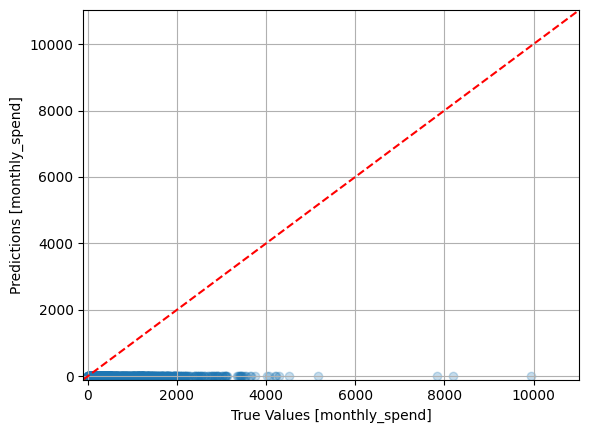

In [14]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count     816.000000
mean     -961.652257
std       972.716172
min     -9934.212453
25%     -1334.516579
50%      -672.982301
75%      -291.998465
max        -1.100597
Name: monthly_spend, dtype: float64

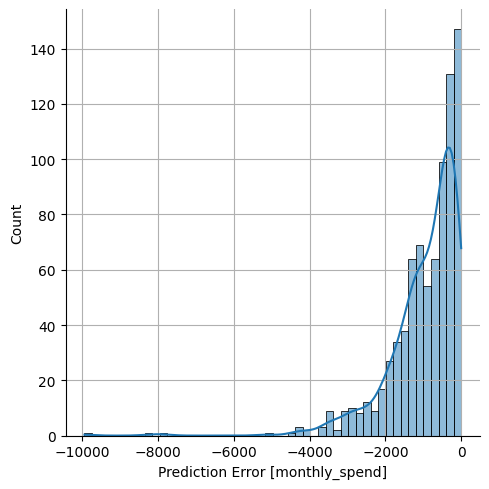

In [17]:
error = test_predictions - test_labels
sns.displot(error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')
error.describe().T

### Treinando a rede

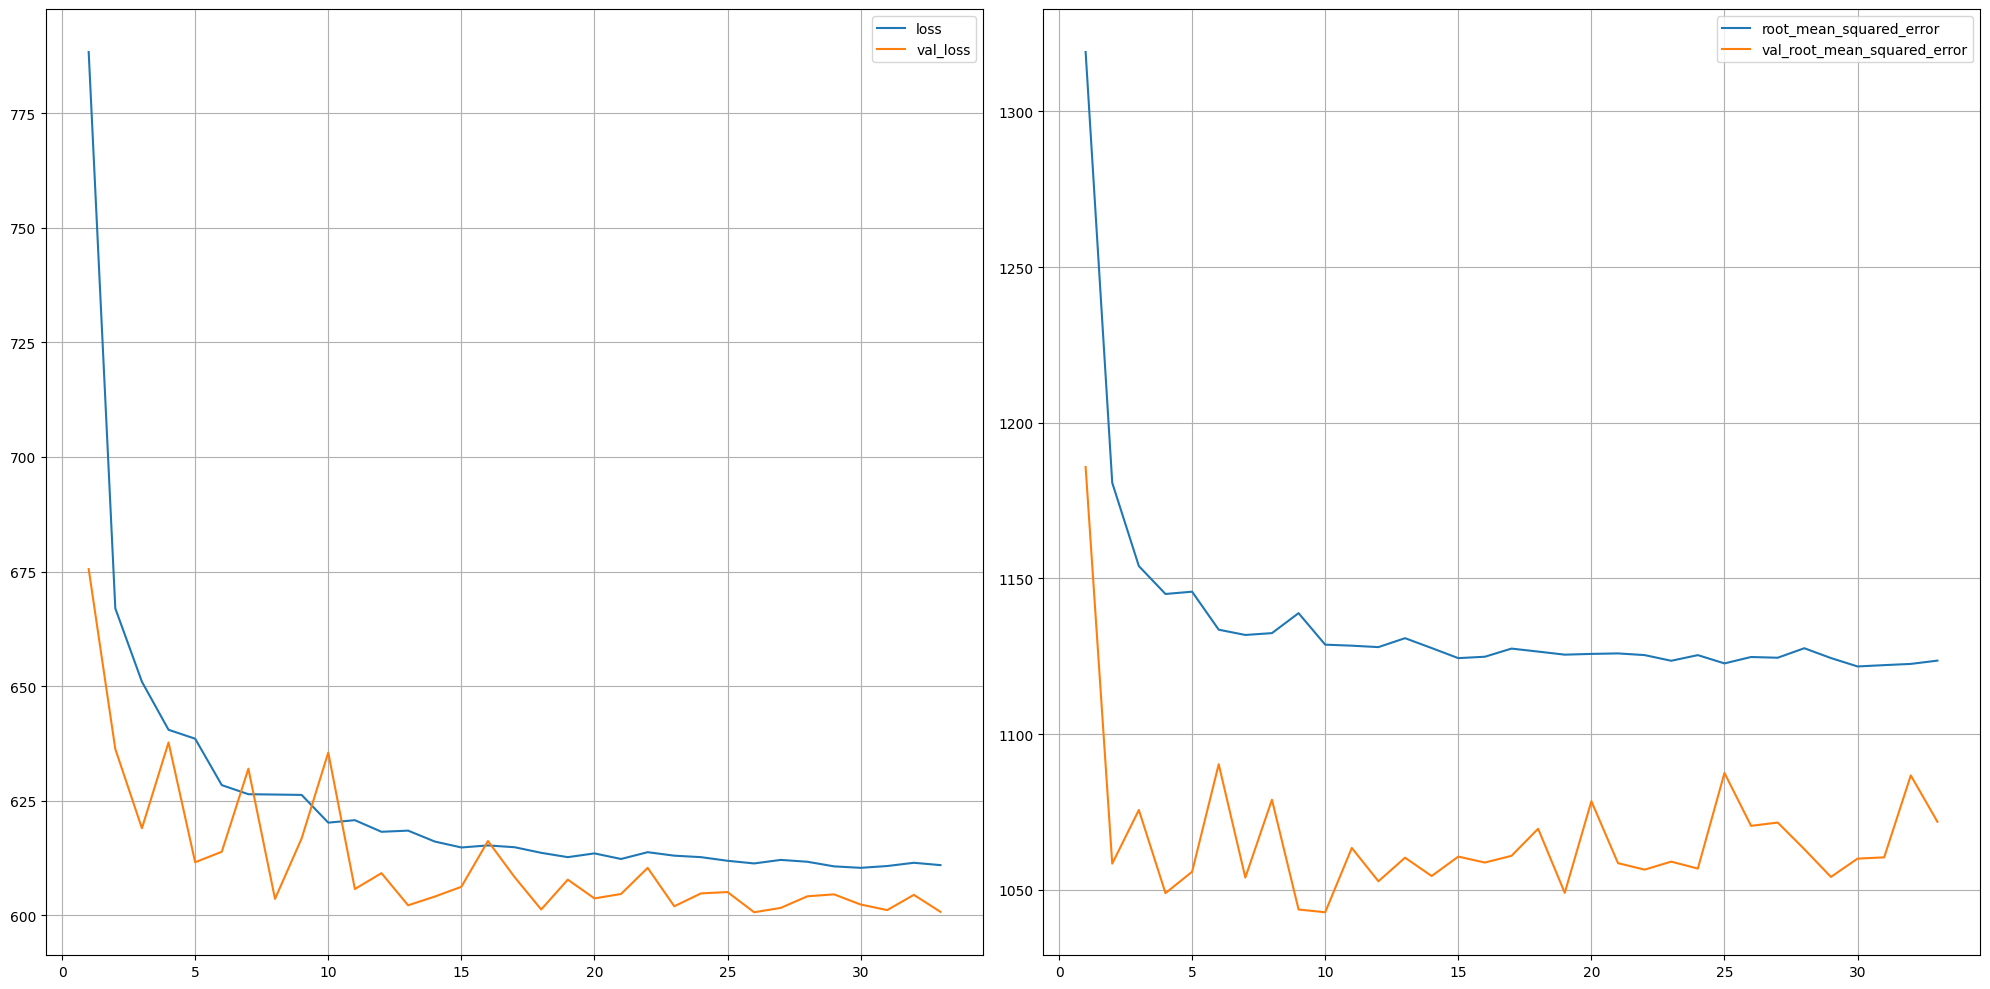

184/184 [==============================] - 0s 3ms/step - loss: 610.9545 - root_mean_squared_error: 1123.6261 - val_loss: 600.7645 - val_root_mean_squared_error: 1071.8723


In [18]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, min_delta=10)]

dnn_model.load_weights('initial_mspend_model.h5')

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=200,
    callbacks=callbacks_list)

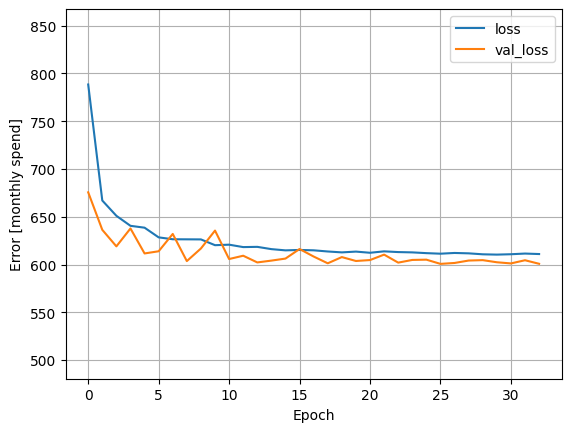

In [25]:
# Historia de treinamento da rede
plot_loss(history)

26/26 [==============================] - 0s 639us/step


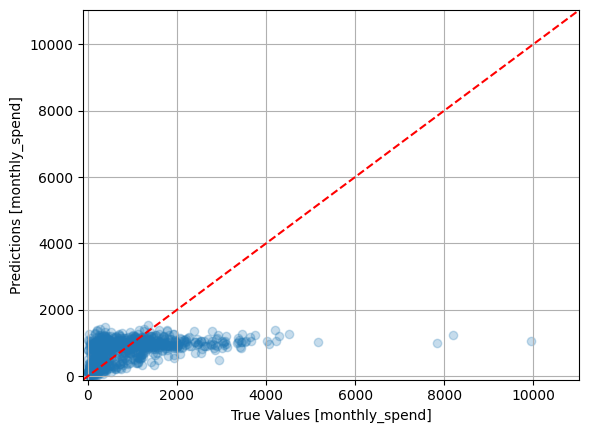

In [26]:
# Avaliação da rede
# Erro Absoulto: 571
# Raiz do EQM: 902

dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count     816.000000
mean      571.384059
std       699.464297
min         0.011765
25%       166.303093
50%       398.966675
75%       723.272858
max      8876.366455
Name: monthly_spend, dtype: float64


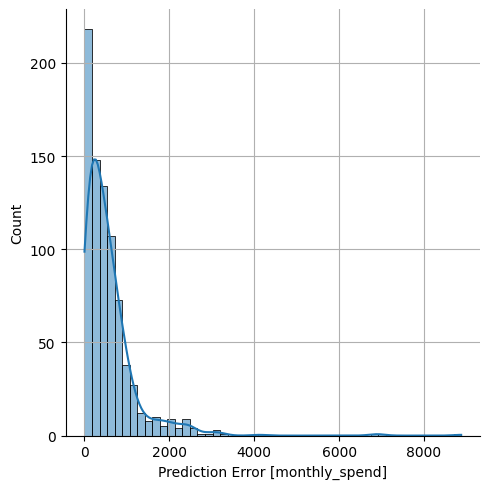

In [27]:
# Plot do perfil do erro
abs_error = np.abs(test_labels - test_predictions)
print(abs_error.describe())
sns.displot(abs_error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')

32/32 [==============================] - 0s 687us/step


count    1000.000000
mean      561.343464
std       674.813884
min         0.391357
25%       153.767506
50%       398.660339
75%       743.393585
max      8533.353882
dtype: float64

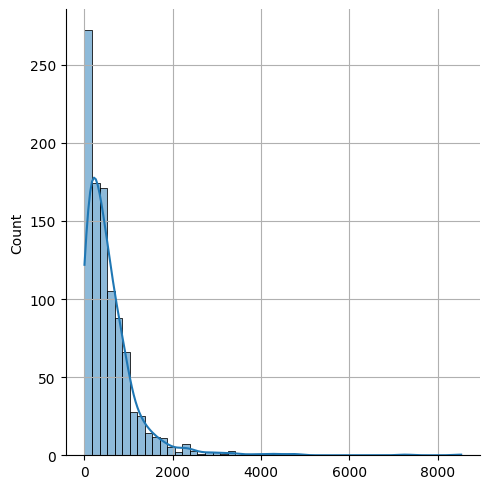

In [12]:
m_spend_model = tf.keras.models.load_model('m_spend_regressor.dnn')

# Grava as predições no dataset separado de teste geral
original_test_dataset = pd.read_json('test_data.json')

test_dataset_features = original_test_dataset[features]
test_dataset_target = original_test_dataset[[target]].copy()

# Pega as predições para o dataset de teste
predictions = dnn_model.predict(test_dataset_features).flatten()
original_test_dataset['predicted_monthly_spend'] = predictions

error = np.abs(test_dataset_target[target] - original_test_dataset['predicted_monthly_spend'])

sns.displot(error, bins=50, kde=True)
plt.grid()
error.describe().T

In [29]:
# Salva o modelo
dnn_model.save('m_spend_regressor.dnn')

INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets


INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets


In [30]:
# Salva o dataset de teste com as predições para a regressão do gasto mensal
original_test_dataset.to_json('test_data_month_pred.json')